In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Data preprocessing

__Section 4.2, Enhanced Deep Residual Networks for Single Image Super-Resolution, by Bee Lim et. al.__
> For training, we use the RGB input patches of size 48×48 from LR image with the corresponding HR patches. We augment the training data with random horizontal flips and 90 rotations. We pre-process all the images by subtracting the mean RGB value of the DIV2K dataset.

### Unsplash dataset

In [2]:
import os
from PIL import Image

def getpaths(path):
    """
    Get all image paths from folder 'path' while avoiding ._ files.
    """
    im_paths = []
    for file in os.listdir(path):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
            continue
        im_paths.append(file)
    im_paths = sorted(im_paths, key=lambda x: int(x.split(".")[0]))
    return im_paths

def calc_mean_std(folder, batch_size=32):
    """
    Calculates the mean and std of a dataset.
    
    Folder: Path to folder containing N images.
    """
    # Initialize variables to accumulate mean & std.
    mean_acc = np.zeros((3,))
    var_acc = np.zeros((3,))
    
    paths = getpaths(folder)
    
    for i in range(0, len(paths), batch_size):
        # Load the current batch of images
        images = []
        for p in paths[i:i+batch_size]:
            image = Image.open(folder + p).resize((1200, 800))
            image = np.asarray(image)
            images.append(image)

        # Stack the images into an array of shape (batch_size, 800, 1200, 3)
        image_array = np.stack(images, axis=0)

        # Compute the mean and variance of the batch
        mean_batch = np.mean(image_array, axis=(0, 1, 2))
        var_batch = np.var(image_array, axis=(0, 1, 2))

        # Accumulate the mean and variance of the batch
        mean_acc += mean_batch * len(images)
        var_acc += var_batch * len(images)

    # Compute the mean and std of the entire dataset
    mean_image = mean_acc / len(paths)
    std_image = np.sqrt(var_acc / len(paths))

    # Save the mean and std values to files
    np.save('params/mean.npy', mean_image)
    np.save('params/std.npy', std_image)

    return mean_image, std_image

def transpose(image):
    # assuming image is stored in the variable 'image'
    image = np.array(image)  # convert to NumPy array
    image = np.transpose(image, (1, 2, 0))  # transpose dimensions
    return image

def visualize_dataset(data, n_samples=3, figsize=(10, 10)):
    '''
    Randomly pick datapoints in `data` and visualize (plot)
    them as a MxN matplotlib grid where MxN evaluates to n_samples.
    Args:
        data: A datasets object (x, y) of type np.ndarray.
        n_samples: An integer that must be a perfect square.
    Returns:
        None.
    Raises:
        AssertionError: If `n_samples` is not int.
    '''
    assert isinstance(n_samples, int)

    # Generate random samples
    samples = [random.randint(0, len(data)-1) for _ in range(n_samples)]    
    
    for i in range(n_samples):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        x = data[samples[i]][0] # low res
        y = data[samples[i]][1] # high res
        
        axs[0].imshow(transpose(x))
        axs[1].imshow(transpose(y))
        
        axs[0].axis('off')
        axs[1].axis('off')      
        
    plt.show()

In [3]:
def get_mean_std(mode="imagenet"):
    if mode == "imagenet":
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
    elif mode == "unsplash":
        try:
            mean, std = np.load('params/mean.npy'), np.load('params/std.npy')
        except FileNotFoundError:
            mean, std = calc_mean_std('dataset/train_set/Unsplash/high_res/')
    else:
        mean = np.array([0.0, 0.0, 0.0])
        std = np.array([1.0, 1.0, 1.0])
    return mean, std

mean, std = get_mean_std(mode="imagenet")
print("Mean: {}, std: {}".format(mean, std))

Mean: [0.485 0.456 0.406], std: [0.229 0.224 0.225]


In [29]:
from data import Unsplash
train_dir = 'dataset/'

scale = 2
patch_size = 48

train_set = Unsplash(
    path=train_dir,
    scale=scale,
    patch_size=patch_size,
    mean=mean,
    std=std,
    train=True,
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=16, shuffle=True
)

__Note:__ The ImageNet dataset is a large-scale dataset of images used for training image classification models. The mean and standard deviation values are often used as a normalization scheme for other image-related tasks, including super-resolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


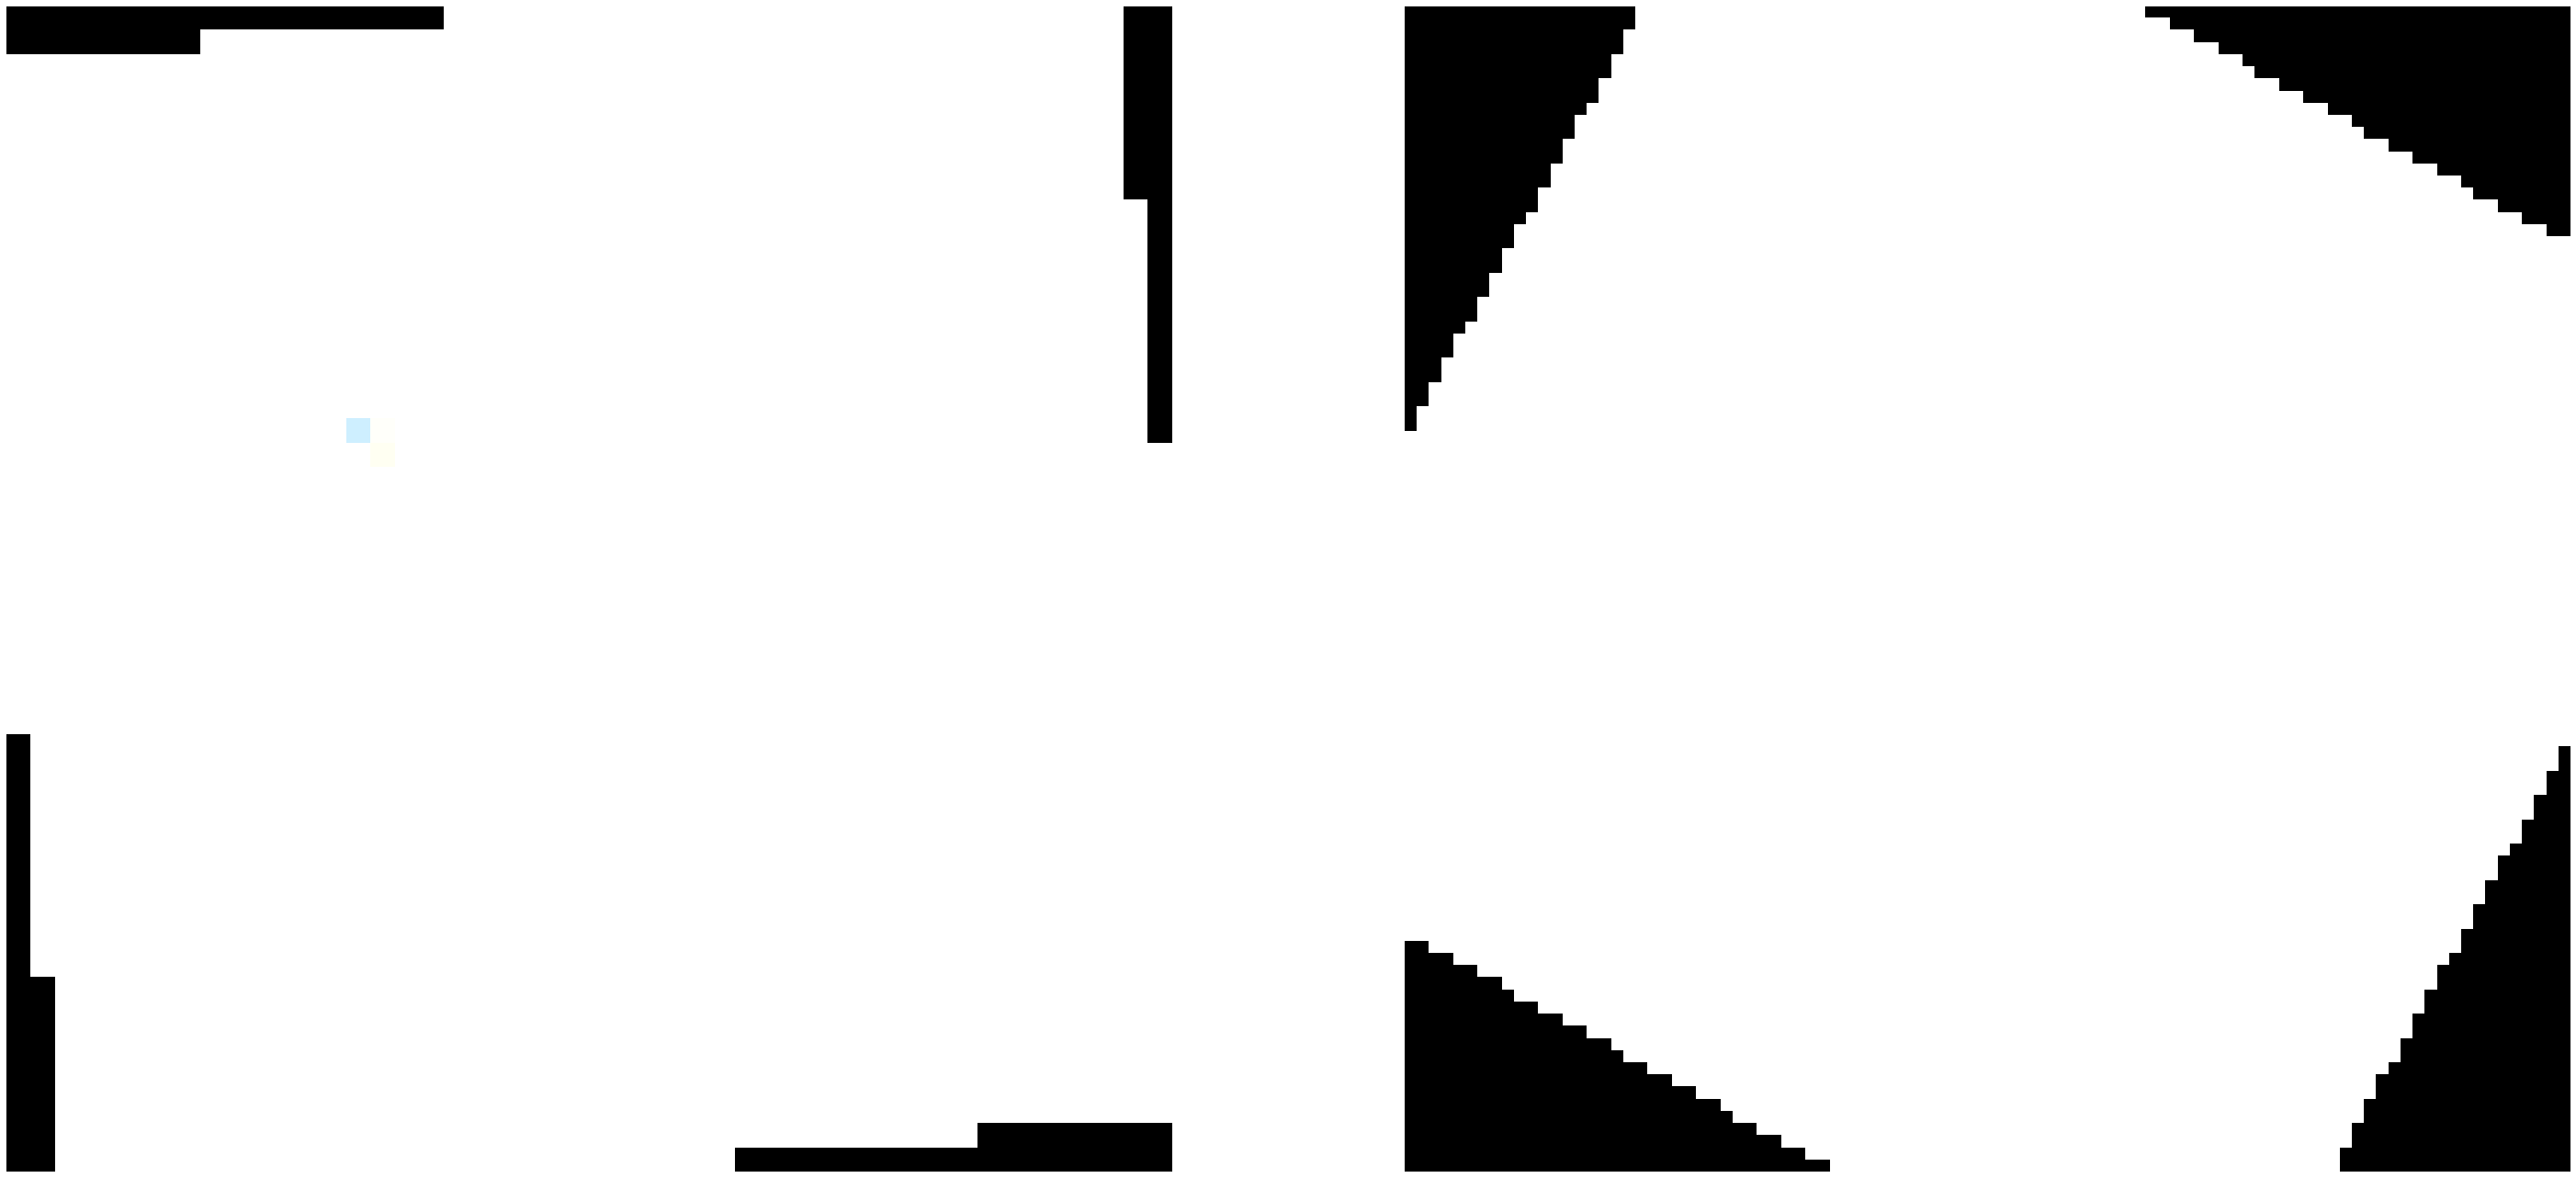

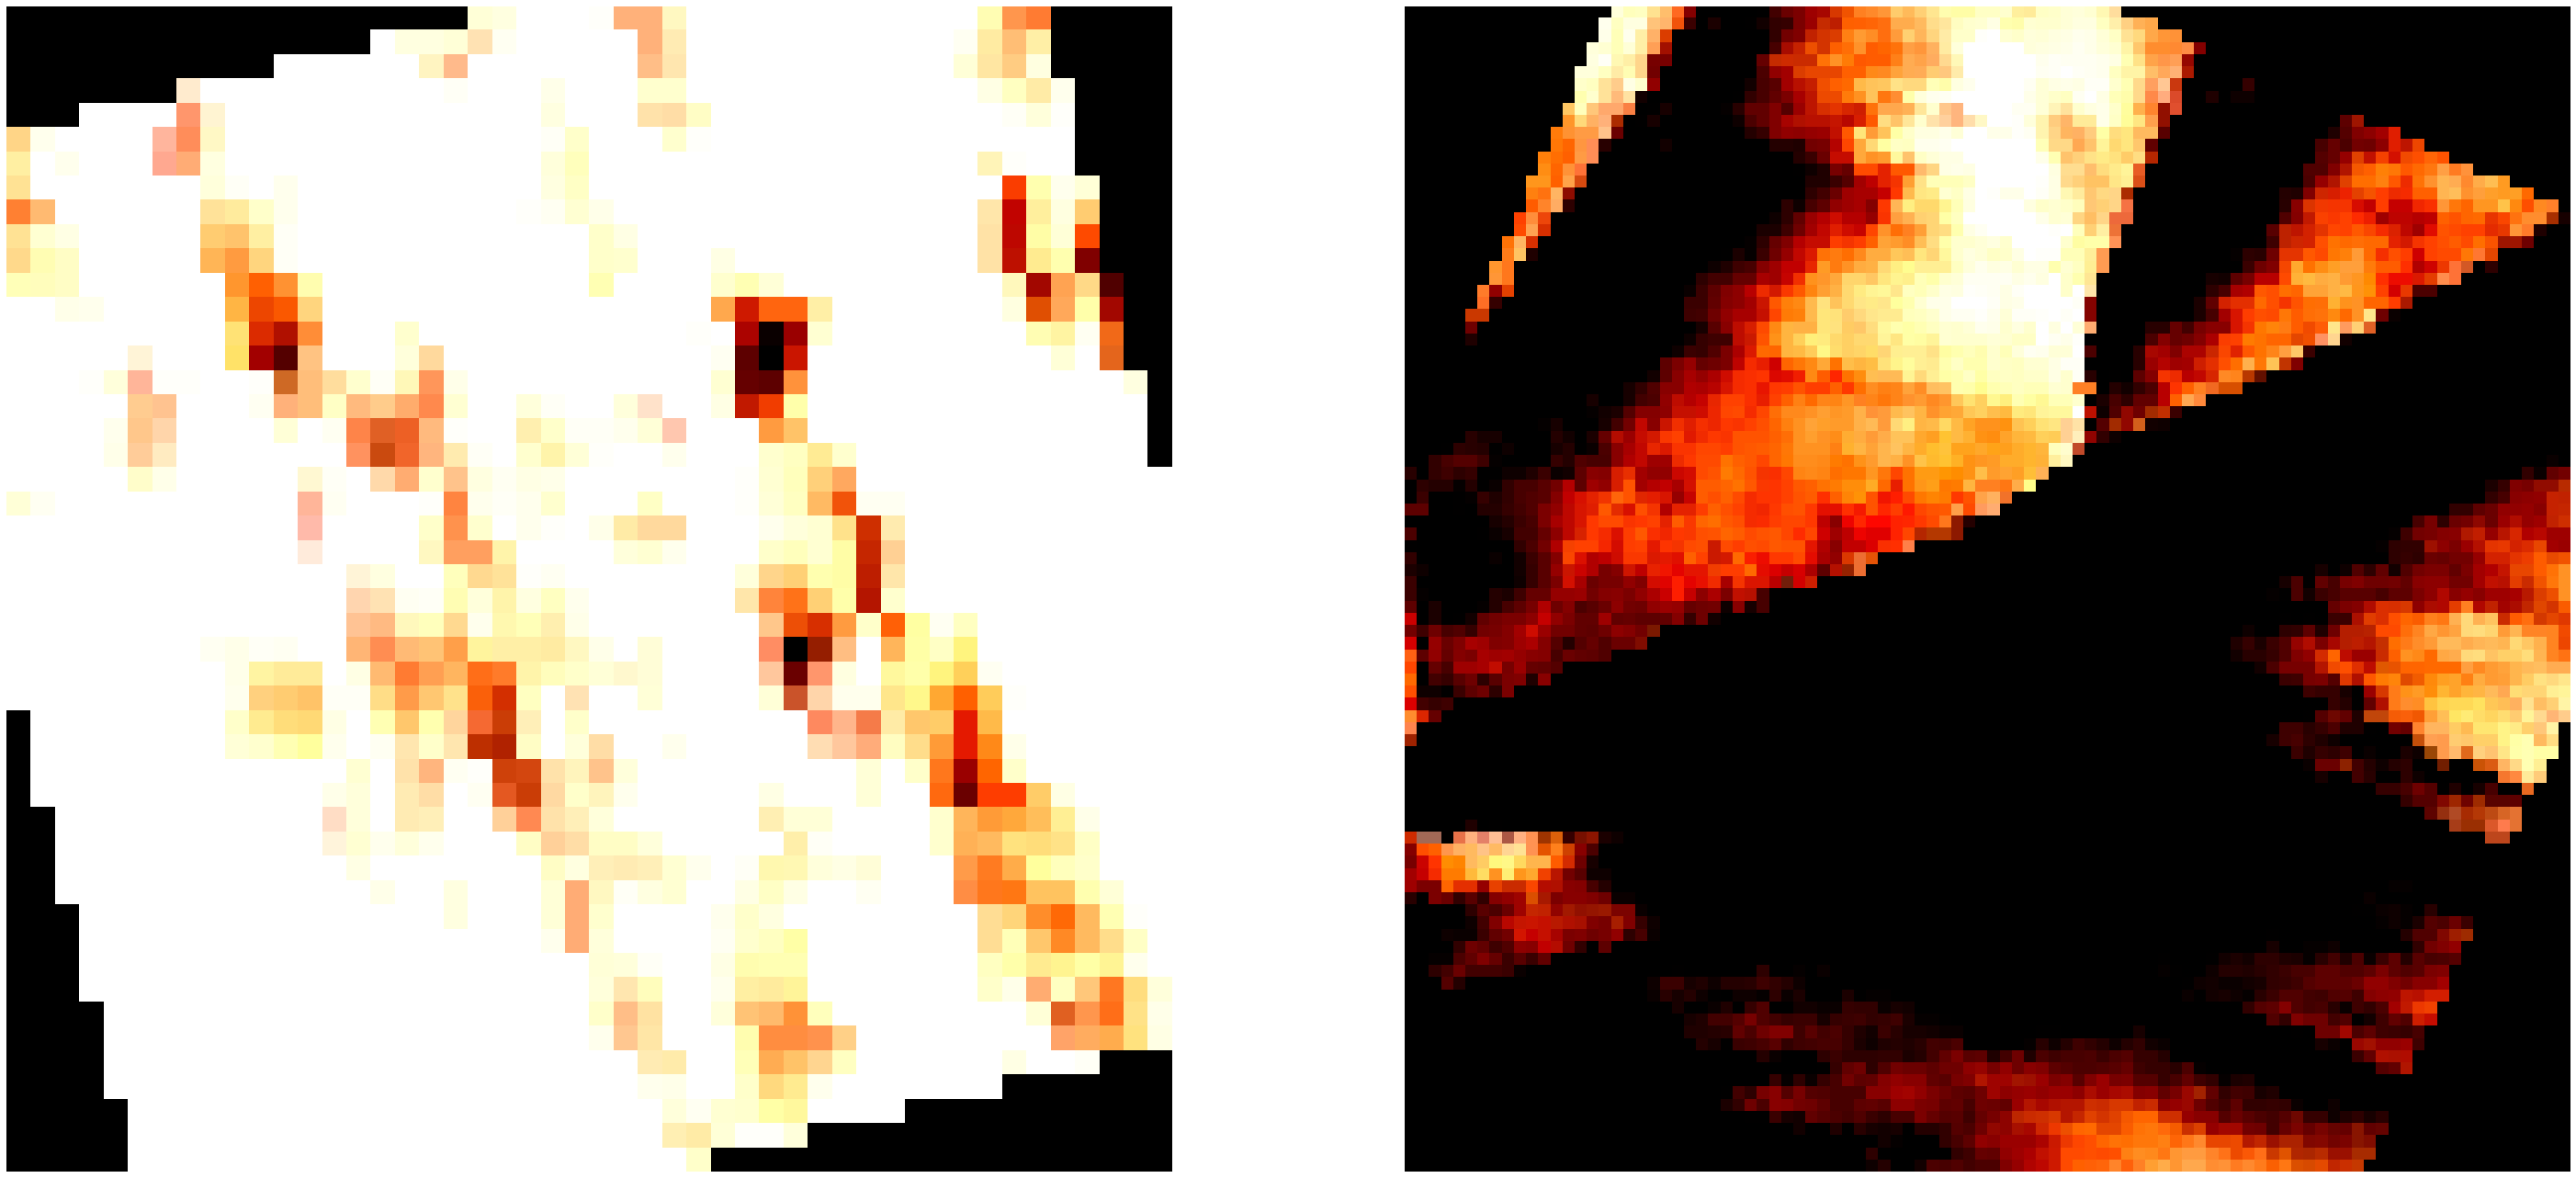

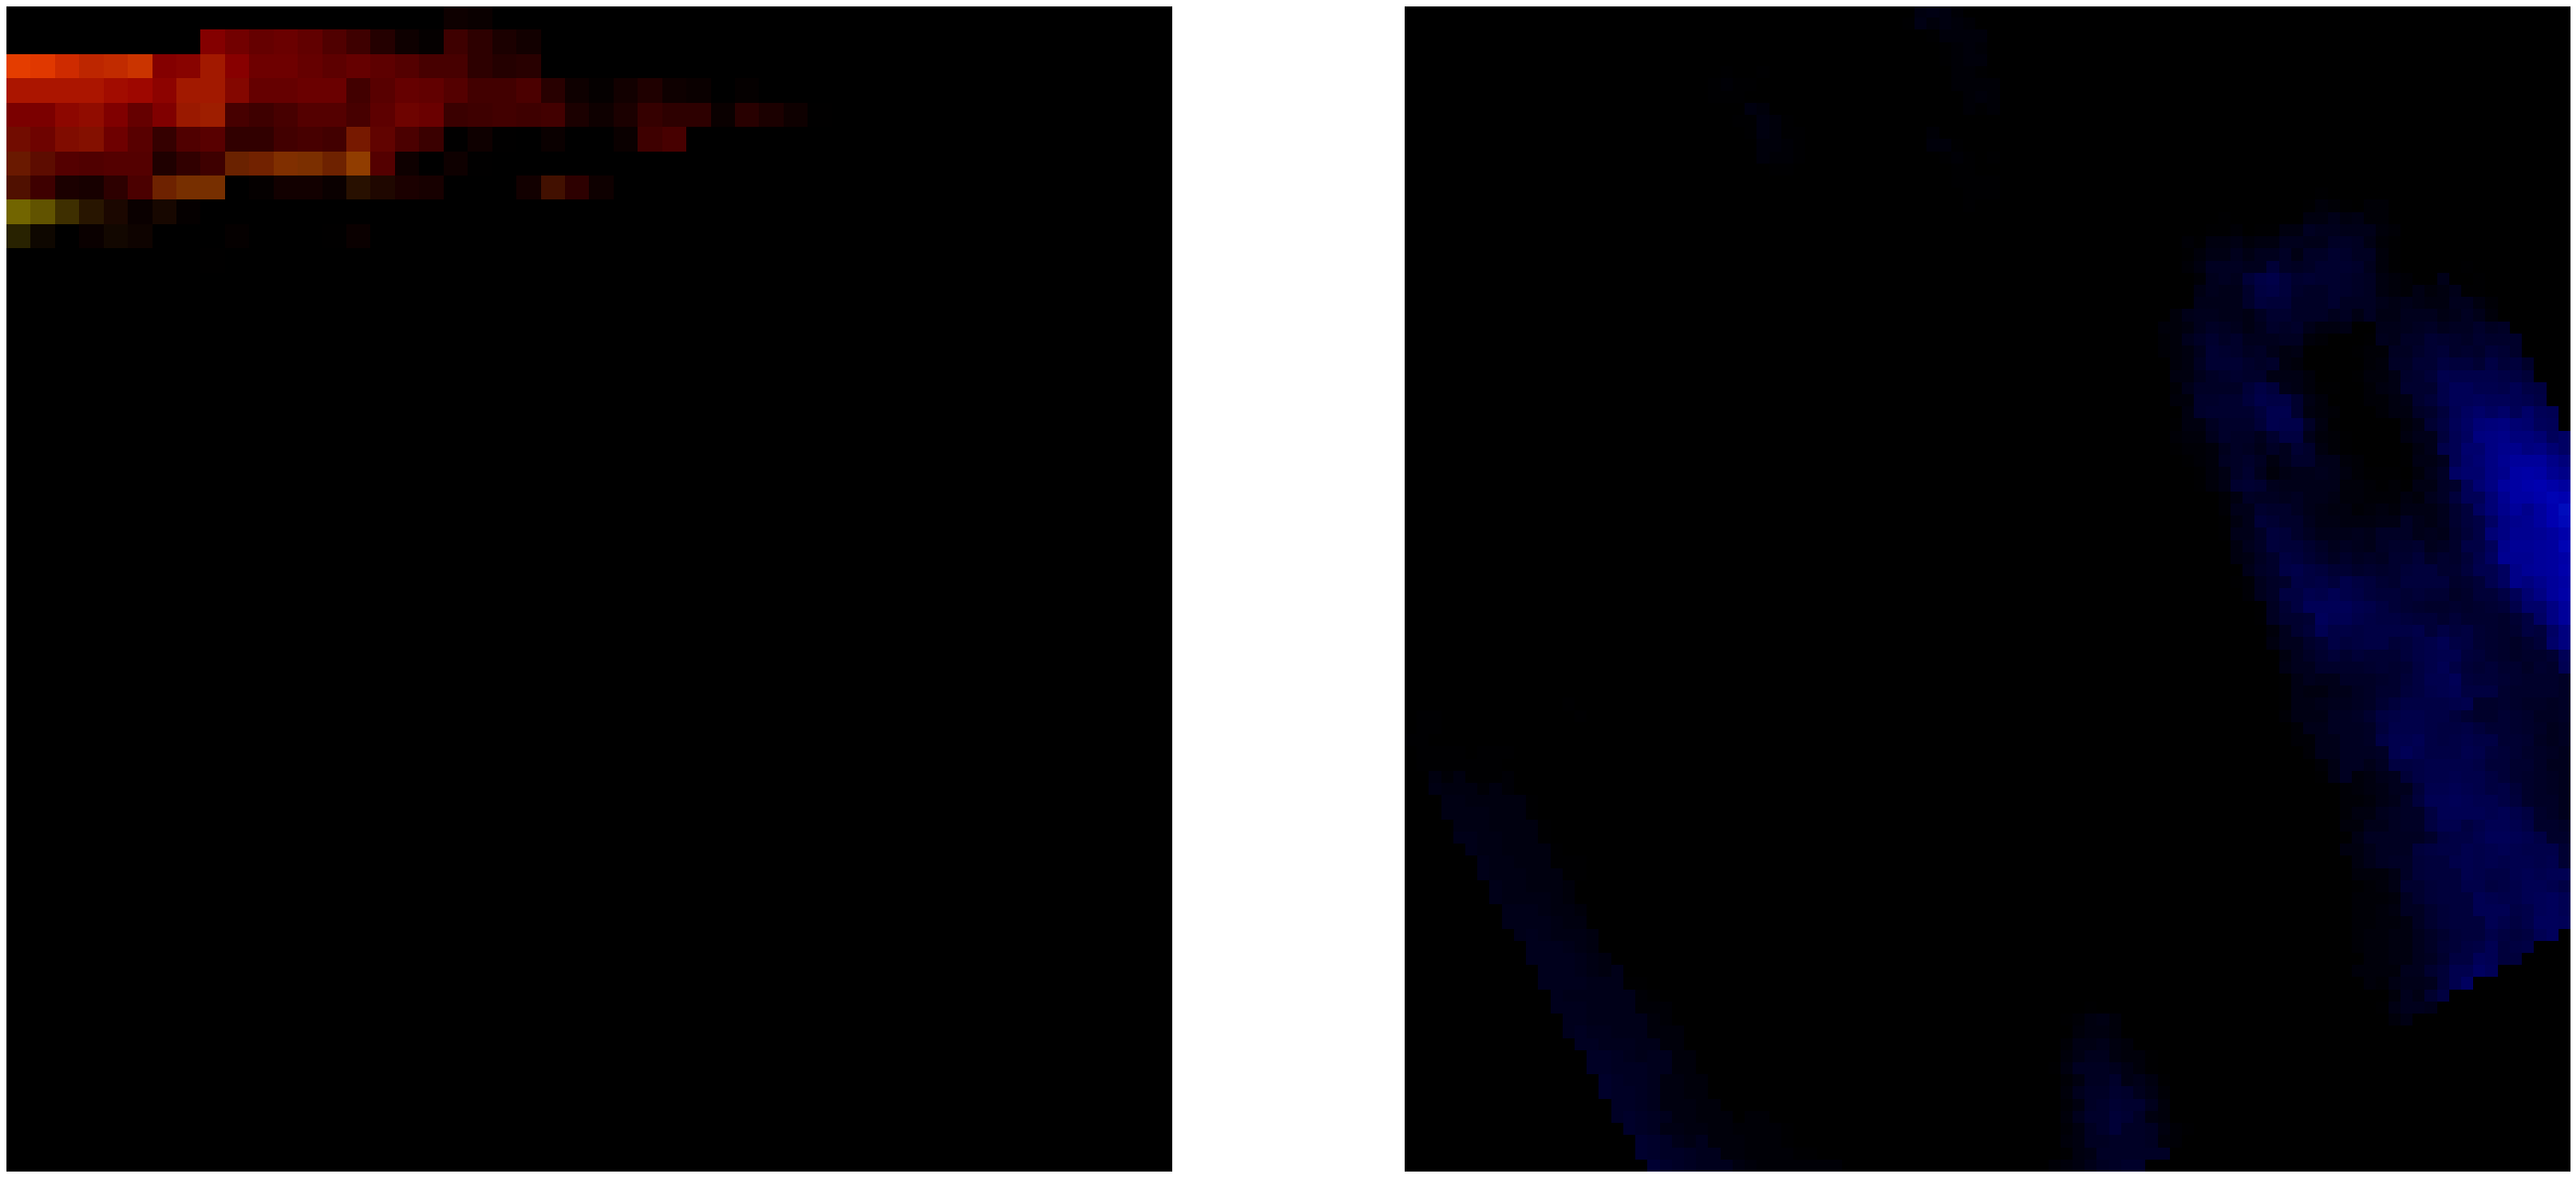

In [30]:
visualize_dataset(train_set, figsize=(50, 50))